# Generalized Metric Learning on Manifolds
`Drew Wilimitis`

![title](images/ex_manifolds.png)

**Note:** This is my attempt to implement and potentially expand on the methods outlined in "Metric Learning on Manifolds" **[1]**, which was implemented by the authors here (https://github.com/m-k-S/manifold_ml)

### Import libraries and load data

In [352]:
import numpy as np
import matplotlib
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

## Generalized Surface Manifolds and Distance Approximation

We restrict our approach to **generalized surfaces** that are globally *diffeomorphic* to an open subset of Euclidean space. Two topological spaces are *diffeomorphic* if there exists a smooth bijection with a smooth inverse between them.<br>

This allows us to frequently define our $d$-dimensional, general surface manifold $S \subset \mathbb{R}^{D}$ in terms of a base space $B \subset \mathbb{R}^{d}$ and the diffeomorphism $F,$ i.e. $S=\{F(x): x \in B\}$. <br>

Although $S$ is in ambient Euclidean space $\mathbb{R}^{D}$, it does not necessarily inherit the ambient metric structure, and so it is significantly easier in theory and implementation to substitute points $x, y \in S$ with $F(b_1), F(b_2)$ 

### Example Manifold Surfaces

In [342]:
# source: https://github.com/index-0/Geometric-Shapes
from mpl_toolkits.mplot3d import Axes3D

def helicoid_map(X):
    """ Map (x1, x2) to (x1*cos(x2), x1*sin(x2), x2) """
    x1 = X[0]
    x2 = X[1]
    helicoid_pt = np.array([x1*np.cos(x2), x1*np.sin(x2), x2])
    return helicoid_pt

def plot_helicoid(angle=720, r=1, c=1, current_ax='None'):
    """ Apply helicoid mapping to sample grid and plot figure """
    if current_ax == 'None':
        fig = plt.figure(figsize=plt.figaspect(1))
        ax = fig.gca(projection='3d')
    else:
        ax = current_ax
    n = angle / 360

    u = np.linspace(0, r, endpoint=True, num=11 * n)
    v = np.linspace(-np.deg2rad(angle), np.deg2rad(angle), endpoint=True, num=22 * n)
    u, v = np.meshgrid(u, v)

    x = u * np.cos(v)
    y = u * np.sin(v)
    z = c * v

    ax.plot_surface(x, y, z, cmap=plt.cm.Spectral)
    ax.set_title('$Helicoid$');

In [343]:
def torus_map(X, R=5, r=1):
    """ Map (u, v) to corresponding points on the torus with major axis = R, minor axis = r """
    u = X[0]
    v = X[1]
    x = np.cos(v) * (R + r * np.cos(u))
    y = np.sin(v) * (R + r * np.cos(u))
    z = r * np.sin(u)
    torus_pt = np.array([x, y, z])
    return torus_pt

def plot_torus(R=5, r=1, current_ax='None'):
    """ Apply torus mapping to sample grid and plot figure """
    if current_ax == 'None':
        fig = plt.figure(figsize=plt.figaspect(1))
        ax = fig.gca(projection='3d')
    else:
        ax = current_ax

    u = np.linspace(0, 2 * np.pi, endpoint=True, num=30)
    v = np.linspace(0, 2 * np.pi, endpoint=True, num=30)
    u, v = np.meshgrid(u, v)

    x = np.cos(v) * (R + r * np.cos(u))
    y = np.sin(v) * (R + r * np.cos(u))
    z = r * np.sin(u)

    ax.plot_surface(x, y, z, cmap=plt.cm.Spectral)
    ax.set_title('$Torus$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    lim = (max(abs(max(np.max(x), np.max(y), np.max(z))), abs(min(np.min(x), np.min(y), np.min(z)))))

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim);

In [348]:
from matplotlib import cm
def hyperboloid_map(X):
    """ Map (x1, x2) to (x1, x2, sqrt(x1**2 + x2**2 + 1))"""
    x1 = X[0]
    x2 = X[1]
    z = np.sqrt(x1**2 + x2**2 + 1)
    hyperboloid_pt = np.array([x1, x2, z])
    return hyperboloid_pt

def hyperboloid_dist(u, v, eps=1e-5):
    """ Explicit, closed form distance between points on the hyperboloid manifold """
    inner_prod = np.dot(u[:-1], v[:-1]) - u[-1]*v[-1]
    dist = np.arccosh(-1*inner_prod)
    if np.isnan(dist):
        return eps
    else:
        return dist

def plot_hyperboloid(current_ax='None'):
    """ Apply hyperboloid mapping to sample grid and plot figure """
    if current_ax == 'None':
        fig = plt.figure(figsize=plt.figaspect(1))
        ax = fig.gca(projection='3d')
    else:
        ax = current_ax
    X = np.arange(-1, 1, 0.05)
    Y = np.arange(-1, 1, 0.05)
    X, Y = np.meshgrid(X, Y)

    Z = np.sqrt(X**2 + Y**2 + 1)

    zcolors = Z - min(Z.flat)
    zcolors = zcolors/max(zcolors.flat)

    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=cm.Spectral(zcolors), linewidth=1)
    ax.set_title('$Hyperboloid$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$');

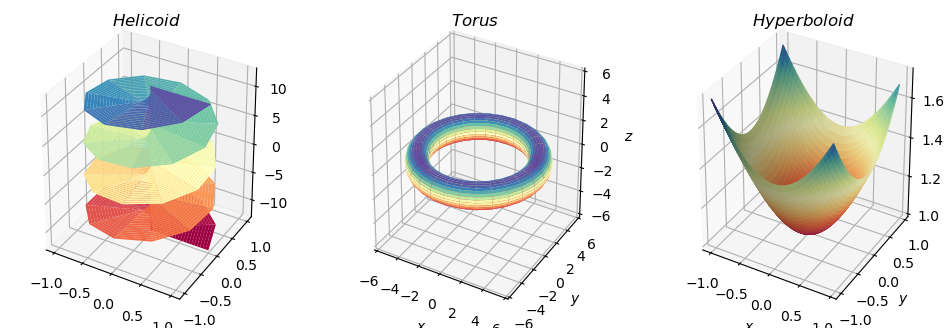

In [351]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1, projection='3d')
plot_helicoid(current_ax=ax)
ax = fig.add_subplot(1, 3, 2, projection='3d')
plot_torus(current_ax=ax)
ax = fig.add_subplot(1, 3, 3, projection='3d')
plot_hyperboloid(current_ax=ax)
plt.savefig('images/ex_manifolds.png')
plt.show();

### Manifold Distance Approximation Algorithm

To approximate the distance between $x, y \in S$, we refer to the base space and consider a set of intermediate points in $B$ given by $F^{-1}(x)=a_{0}, a_{1}, \ldots, a_{n}, a_{n+1}=F^{-1}(y)$

We have the manifold distance along an intermediate path:

$$
\sigma\left(a_{i}, a_{i+1}\right):=\int_{0}^{1} \sqrt{\left\langle\frac{d}{d t} F(\bar{\kappa}(t)), \frac{d}{d t} F(\bar{\kappa}(t))\right\rangle} d t
$$

where the straight line path between successive intermediate points is given by $\bar{\kappa}(t)=(1-t) a_{i}+t a_{i+1}$ <br>

**Note:** Assumes $B$ is convex

![title](images/dist_alg.png)

In [364]:
from scipy import integrate

def integrand_helicoid(t, x, y, Q=np.eye(2)):
    Pth = (1 - t) * x + (y * t)
    Dff = y-x   # 2 x 1

    r = Pth[0]
    s = Pth[1]
    D = [[np.cos(s), -r * np.sin(s)],
        [np.sin(s), r * np.cos(s)],
        [0, 1]]

    v = np.matmul(D, np.matmul(Q, Dff))
    return np.linalg.norm(v) # (D*Q*(y-x))^T (D*Q*(y-x))

def integrand_hyperboloid(t, x, y):
    Pth = (1 - t) * x + (y * t)
    Dff = y - x   # 2 x 1
    K = 1 / np.sqrt(1 + np.dot(Pth, Pth)) * Pth
    
    D = [[1, 0],
         [0, 1],
         [K[0], K[1]]]
    
    G = [[1, 0, 0],
         [0, 1, 0],
         [0, 0, -1]]
    
    k_dot = np.array([-x + y]).T
    
    Dk = np.matmul(D, k_dot)

    v = np.sqrt(np.matmul(Dk.T, np.matmul(G, Dk)))
    return v

In [454]:
def approximate_distance(a, b, integrand, L=None, n=7, m=50, tol=1e-6):
    """
    Approximate manifold distance between the diffeomorphic mappings F(a)=x and F(b)=y 
    Parameters
    ----------
    a : F^-1 (x), point in Euclidean base space B, initial point in linear sequence a0, ..., a_n+1
    b : F^-1 (y), point in Euclidean base space B, endpoint of linear sequence a0, ..., a_n+1
    L : optional linear transformation matrix L applied to B, if none use identity matrix
    n : number of intermediate points between a,b in sequence a0, a1, ..., a_n+1
    m : number of bi sampled from base space at each intermediate point
    """
    base_dim = len(a)
    if L == None:
        L = np.eye(base_dim)
    if not (len(a) == len(b) == L.shape[0]):
        print('Input dimensions do not match!')
        return
    
    # create list with sequence a0, ..., a_n+1 of linearly spaced intermediate points
    linear_seq = []
    linear_seq.append(a)
    for i in range(n):
        delta = (i + 1) / (n + 1) * (b - a)
        linear_seq.append(a + delta)
    linear_seq.append(b)
    
    convergence = True
    while convergence is True:
        convergence = False
        
        for i, alpha in enumerate(linear_seq[1:-1]):
            index = i + 1
            current_pt = alpha
            prev_pt = linear_seq[index - 1]
            next_pt = linear_seq[index + 1]
            
            # arc length integrals
            length_1 = integrate.quad(integrand, 0, 1, args=(prev_pt, current_pt))[0] 
            length_2 = integrate.quad(integrand, 0, 1, args=(current_pt, next_pt))[0] 
            
            radius = 2. * max(np.linalg.norm(current_pt - prev_pt), np.linalg.norm(next_pt - current_pt))
            samples = np.random.uniform(-radius, radius, size=(m, base_dim)) + alpha # radius ball centered at alpha
            min_dist = length_1 + length_2
            best_pt = current_pt

            # find min intermediate path distance and update values
            for sample_pt in samples:
                length_1 = integrate.quad(integrand, 0, 1, args=(prev_pt, current_pt))[0]
                length_2 = integrate.quad(integrand, 0, 1, args=(current_pt, next_pt))[0] 
                sample_dist = length_1 + length_2
                if sample_dist < min_dist:
                    min_dist = sample_dist
                    best_pt = sample_pt
            linear_seq[i] = best_pt

            # if any updates aren't less than the tolerance, continue while loop
            if not np.linalg.norm(current_pt - best_pt) < tol:
                convergence = True
                
    total_dist = 0
    for i in range(len(linear_seq)-1):
        path_dist = integrate.quad(integrand, 0, 1, args=(linear_seq[i], linear_seq[i+1]))[0]
        total_dist += path_dist

    return total_dist

In [457]:
def test_approximations(n_samples, parameter_n_range):
    n_trials = len(parameter_n_range)
    s = np.random.uniform(-2, 2, size=(n_samples, 2))
    r = np.random.uniform(-2, 2, size=(n_samples, 2))
    result_dict = {}
    for n in parameter_n_range:
        errors = []
        for i in range(n_samples):
            x = hyperboloid_map(r[i])
            y = hyperboloid_map(s[i])
            true_dist = hyperboloid_dist(x, y)
            errors.append(approximate_distance(s[i], r[i], integrand_hyperboloid, n=n, m=10) / true_dist)
        result_dict[n] = errors
    return result_dict

params = [1, 2, 3, 4, 5, 6, 7]
scores = test_approximations(5, params)

mean_ratios = []
std_dev = []
for item in scores.values():
    mean_ratios.append(1/np.mean(item))
    std_dev.append(np.std(item))

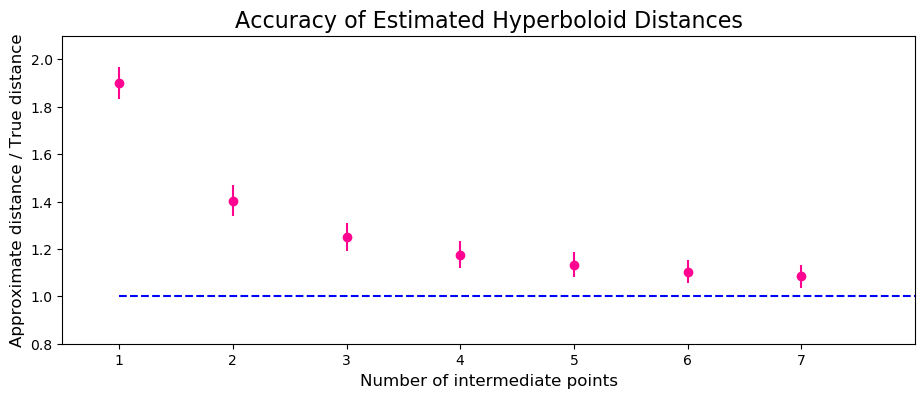

In [458]:
plt.figure(figsize=(11,4))
plt.style.use('default')
plt.errorbar(np.arange(1, len(params)+1), mean_ratios, yerr=std_dev, fmt='o', color='#ff0490')
ax = plt.gca()
ax.set_xticks(np.arange(1, len(params)+1))
plt.ylabel('Approximate distance / True distance', size=12)
plt.xlabel('Number of intermediate points', size=12)
plt.title('Accuracy of Estimated Hyperboloid Distances', size=16)
plt.ylim(0.8, np.max(mean_ratios)+0.2)
plt.xlim(0.5, len(params)+1)
plt.plot([1, len(params)+1], [1, 1], 'b--')
plt.show();

## Metric Learning

### Mahalanobis Metric for Clustering (MMC)

MMC involves finding an optimal linear transformation that groups similar data points (set $P$) together and pushes dissimilar data points (set $Q$) further away. The standard MMC optimization problem is given as: 

$$
\min _{L \in \mathbb{R}^{d \times d}} \underbrace{\sum_{\left(x_{i}, x_{j}\right) \in P}\left\|L x_{i}-L x_{j}\right\|^{2}}_{\text {push term }} -\lambda \underbrace{\sum_{\left(x_{i}, x_{j}\right) \in Q}\left\|L x_{i}-L x_{j}\right\|^{2}}_{\text {pull term }}
$$
<br>
and for manifolds we have a linear transformation $L$ applied to $B$ with the manifold distance

$$
\rho_{L}^{F}\left(x_{i}, x_{j}\right):=\rho^{F}\left(F\left(L b_{i}\right), F\left(L b_{j}\right)\right)
$$

We can rewrite the optimization problem for generalized manifolds:

$$
\min _{L \in \mathbb{R}^{d \times d}} \sum_{\left(x_{i}, x_{j}\right) \in P} \rho_{L}^{F}\left(x_{i}, x_{j}\right)-\lambda \sum_{\left(x_{i}, x_{j}\right) \in Q} \rho_{L}^{F}\left(x_{i}, x_{j}\right)
$$

In [589]:
def similar_pairs(labels):
    """ Generate similarity/dissimilarity pair sets based on indices with the same label """
    P = [] # set of similar pairs
    Q = [] # set of dissimilar pairs
    n = len(labels)
    for i in range(n):
        for j in range(i+1, n):
            if labels[i] == labels[j]:
                P.append([i, j])
            else:
                Q.append([i, j])
    return P, Q

def mmc_loss(L, B, labels, manifold_map_fn, integrand, manifold_dist_fn=None, C=0.1, scaling_penalty=10):
    """
    Function to calculate the MMC loss for generalized manifold surfaces
    Parameters
    ----------
    L : optimization argument we seek to find, linear transformation matrix L applied to B
    B : set of m points b1, ..., bm in Euclidean base space
    labels : set of m classification labels y1, ..., ym
    manifold_map_fn : function F that maps points in B to manifold S
    manifold_dist_fn : explicit distance function on the manifold, if none then approximate
    integrand: arc length formula for piecewise linear distance approximation
    C: constant parameter controlling degree of push/pull in optimization routine 
    """
    
    # to use explicit manifold distance formulas, need to get manifold points by applying F to B
    dim = len(B[0])
    L = L.reshape(dim, dim)
    X = []
    for b in B:
        X.append(manifold_map_fn(np.matmul(L, b)))
    
    # get similarity pair indices
    similar_ix, dissimilar_ix = similar_pairs(labels)
    
    # get first summation term
    push = 0
    for i, j in similar_ix:
        if manifold_dist_fn == None: # approximation method
            d_ij = approximate_distance(np.matmul(L, B[i]), np.matmul(L, B[j]), integrand=integrand, n=3, m=1, tol=0.01)
        else:
            d_ij = manifold_dist_fn(X[i], X[j])
        push += (1 - C) * d_ij / len(similar_ix)
#        print('Similar pair {}, {}'.format(i, j))
            
    # get second summation term
    pull = 0
    for i, j in dissimilar_ix:
        if manifold_dist_fn == None: # approximation method
            d_ij = approximate_distance(np.matmul(L, B[i]), np.matmul(L, B[j]), integrand=integrand, n=3, m=1, tol=0.01)
        else:
            d_ij = manifold_dist_fn(X[i], X[j])
        pull += C * d_ij / len(dissimilar_ix)
    
    loss = push - pull + scaling_penalty*(np.matmul(L.T, L).sum())
    return loss

In [590]:
Q0_mfd = np.eye(2)
L = Q0_mfd
sample = np.array([np.random.uniform(-1, 1, 20), np.random.uniform(-1, 1, 20)]).T
tmp_labels = [int(x) for x in sample[:,1] < 0]
B = sample

mfd_res_Powell = minimize(mmc_loss, Q0_mfd,
                          args=(sample, tmp_labels, hyperboloid_map, integrand_hyperboloid),
                          method='Powell', options={'disp': True, 'maxfev': 50})

L_new = mfd_res_Powell.x.reshape(2,2)

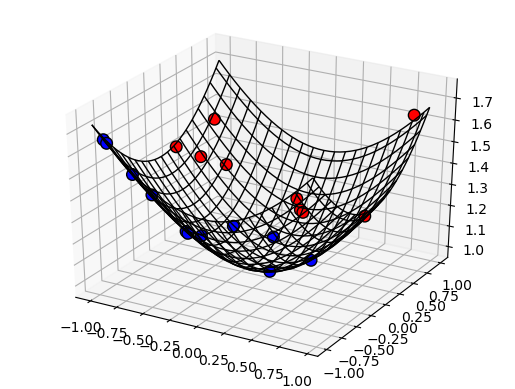

In [591]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
hyp_pts = []
for s in sample:
    hyp_pts.append(hyperboloid_map(s))
hyp_pts = np.array(hyp_pts)
colors = ['red', 'blue']
ax.scatter(hyp_pts[:,0], hyp_pts[:,1], hyp_pts[:,2],
           c=[colors[x] for x in tmp_labels], s=70, edgecolor='black', alpha=1)
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
X, Y = np.meshgrid(X, Y)

Z = np.sqrt(X**2 + Y**2 + 1)

surf = ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=1, edgecolor='black')
plt.show();

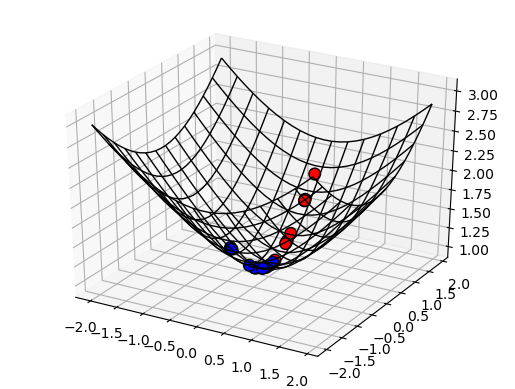

In [592]:
new_points = []
for s in sample:
    new_points.append(np.matmul(L_new, s))
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
hyp_pts = []
for s in new_points:
    hyp_pts.append(hyperboloid_map(s))
hyp_pts = np.array(hyp_pts)
colors = ['red', 'blue']
ax.scatter(hyp_pts[:,0], hyp_pts[:,1], hyp_pts[:,2],
           c=[colors[x] for x in tmp_labels], s=70, edgecolor='black', alpha=1)
X = np.arange(-2, 2, 0.15)
Y = np.arange(-2, 2, 0.15)
X, Y = np.meshgrid(X, Y)

Z = np.sqrt(X**2 + Y**2 + 1)

surf = ax.plot_wireframe(X, Y, Z, rstride=2, cstride=2, linewidth=1, edgecolor='black')
plt.show();

In [579]:
sample = np.array([np.random.uniform(0, 1, 20), np.random.uniform(-np.deg2rad(360), np.deg2rad(360), 20)]).T
tmp_labels = [int(x) for x in sample[:,1] < 0]

mfd_res_Powell = minimize(mmc_loss, Q0_mfd,
                          args=(sample, tmp_labels, helicoid_map, integrand_helicoid),
                          method='Powell', options={'disp': True, 'maxfev': 50})

L_new = mfd_res_Powell.x.reshape(2,2)
mfd_res_Powell

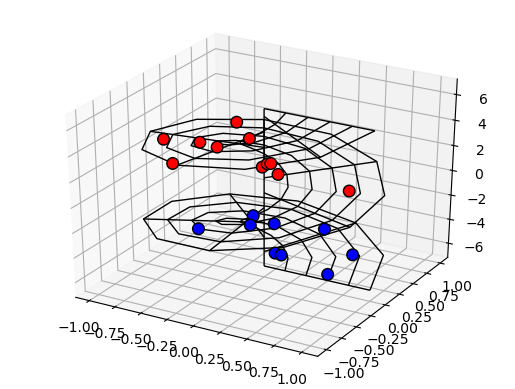

In [583]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
heli_pts = []
for s in sample:
    heli_pts.append(helicoid_map(s))
heli_pts = np.array(heli_pts)
colors = ['red', 'blue']
ax.scatter(heli_pts[:,0], heli_pts[:,1], heli_pts[:,2], 
           c=[colors[x] for x in tmp_labels], s=70, edgecolor='black', alpha=1)

angle=360
n = angle / 360
u = np.linspace(0, 1, endpoint=True, num=11 * n)
v = np.linspace(-np.deg2rad(angle), np.deg2rad(angle), endpoint=True, num=22 * n)
u, v = np.meshgrid(u, v)

x = u * np.cos(v)
y = u * np.sin(v)
z = c * v

#ax.plot_surface(x, y, z, cmap=plt.cm.Spectral)
surf = ax.plot_wireframe(x, y, z, rstride=2, cstride=2, linewidth=1, edgecolor='black')
plt.show();

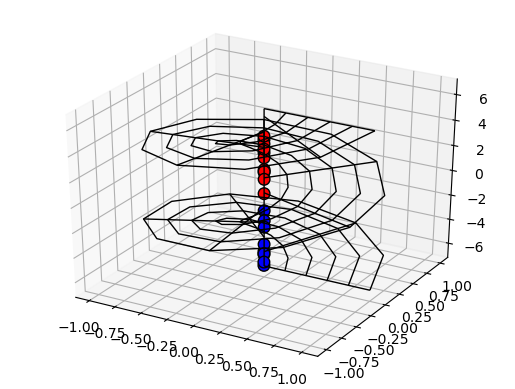

In [585]:
new_points = []
for s in sample:
    new_points.append(np.matmul(L_new, s))
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
heli_pts = []
for s in new_points:
    heli_pts.append(helicoid_map(s))
heli_pts = np.array(heli_pts)
ax.scatter(heli_pts[:,0], heli_pts[:,1], heli_pts[:,2], 
           c=[colors[x] for x in tmp_labels], s=70, edgecolor='black', alpha=1)

angle=360
n = angle / 360
u = np.linspace(0, 1, endpoint=True, num=11 * n)
v = np.linspace(-np.deg2rad(angle), np.deg2rad(angle), endpoint=True, num=22 * n)
u, v = np.meshgrid(u, v)

x = u * np.cos(v)
y = u * np.sin(v)
z = c * v

#ax.plot_surface(x, y, z, cmap=plt.cm.Spectral)
surf = ax.plot_wireframe(x, y, z, rstride=2, cstride=2, linewidth=1, edgecolor='black')
plt.show();

### Large Margin Nearest Neighbor (LMNN) for Improved Nearest Neighbors Classification

Rather than considering global relationships like in MMC, LMNN attempts to maximize local similarities defined by the neighbor relationship $x_i \sim x_j$ and minimize local classification dissimilarities denoted by $x_l \succ x_i$  
<br>

$$
\min _{L \in \mathbb{R}^{d \times d}} \underbrace{\sum_{i, j \sim i} \rho_{L}^{F}\left(x_{i}, x_{j}\right)}_{\text {push term on } S}+\lambda \underbrace{\sum_{i, j \sim i, l \succ i}\left[1+\rho_{L}^{F}\left(x_{i}, x_{j}\right)-\rho_{L}^{F}\left(x_{i}, x_{l}\right)\right]_{+}}_{\text {pull term on } S}
$$

# References
___

**1.]** Aalto, M., & Verma, N. (2019). Metric Learning on Manifolds. ArXiv, abs/1902.01738 